In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14


In [2]:
import numpy as np
import pandas as pd
from collections import namedtuple
import os
import glob
from pathlib import Path

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
from torchsummary import summary
from torchvision.transforms import v2

In [4]:
from pymono.cnns import x_cnn_evaluation, x_single_run, x_train_cnn
from pymono.cnns import Conv2dPars,  MaxPool2dPars,  LinealLayerPars
from pymono.cnns import build_conv_layer, build_conv_layers, build_linear_layers
from pymono.cnns import xCNN, xResNet10, xResNet8, ResBlock

In [5]:
from pymono.plt_funcs import  plot_loss, plot_accuracy, cifar_plot_image_and_label 
from pymono.plt_funcs import  plot_energies2, histoplot, plotxyz, plot_dataset
from pymono.cnn_plots import plot_images2, plot_images2c
from pymono.cnn_plots import plot2c_z, plot_images_and_labels, plot_images_and_positions

In [6]:
from pymono.cnn_aux import get_file_names_format1, get_image_file_data, get_img_file_metadata
from pymono.cnn_aux import get_energy2, get_means_stds2

In [7]:
from pymono.xdataset import XDataset, RDataset, R2Dataset
from pymono.mono_dl import mono_data_loader
from pymono.cnn_eval import evaluate_cnn, evaluate_2c_cnn, cnn_xeval, single_run, train_cnn

In [8]:
from pymono.cnn_func import CNN_basic
from pymono.cnn_func import  CNN

In [9]:
from pymono.cnn_eval import cnn_evaluation 

In [10]:
from pymono.cnn_fit import fit_coord, fit_tdeltas, plotfxyz

In [11]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


## Voxelization at 6-12 mm
- df1c is the directory containing images and labels for events classified as single cluster (1c)
- df2c is the directory containing images and labels for events classified as double cluster (2c)
- Files are in format1:
    - images files are of the form: images_n.npy, where n is a number.
 
- Data corresponds to CsI

In [14]:
data_dir = Path(os.environ['MONOLITH_DATA'])
dir_root = os.path.join(data_dir,"CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_vox_xy_6_z_12")
d1c = os.path.join(dir_root,"df1c")
d2c = os.path.join(dir_root,"df2c")

In [15]:
d1c

'/home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_vox_xy_6_z_12/df1c'

In [16]:
img_names, csv_name = get_file_names_format1(d1c)

In [17]:
img_names[0]

'/home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_vox_xy_6_z_12/df1c/images_1.npy'

In [18]:
csv_name

['/home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_vox_xy_6_z_12/df1c/df1c_xy_6_z_12.csv']

### Label data
- When sorted by value, label data corresponds to the image stored in the directory.
- event_id = 10000 x image_number, so that event 1004 corresponds to the fourth image in file images_1.npy

In [19]:
df1c = pd.read_csv(csv_name[0])
df1c.head(10)

,event_id,e,x,y,z,t
0,10004,0.510118,18.645067,12.477487,29.249544,0.116340
1,10006,0.509274,13.566376,1.647984,21.156849,0.090734
2,10014,0.509922,-5.014233,5.060986,12.715019,0.062352
3,10018,0.508170,-22.957691,-9.322307,45.483715,0.171746
4,10024,0.508948,-3.514938,-0.639491,15.746504,0.074194
5,10026,0.508879,18.973616,-6.031100,16.421364,0.074508
6,10027,0.508849,11.437413,-22.155209,40.912632,0.157729
7,10028,0.509717,9.708068,3.101630,13.316263,0.064982
8,10029,0.509517,0.335767,-11.193620,21.898740,0.093051
9,10030,0.509092,16.716444,15.401320,25.922293,0.107143


#### Example
- Images and labels in first file of directory

In [20]:
imgs, imgf_path, imgf_name, imfn = get_image_file_data(img_names,img_file_index=0)
print(f"image file path = {imgf_path}")
print(f"image file name = {imgf_name}")
print(f"image file number = {imfn}")
print(f"number of images in file = {len(imgs)}")

df1cs = get_img_file_metadata(df1c, imfn)  # This are the events corresponding to the images
print(f"number of labels in file = {len(df1cs)}")


image file path = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_vox_xy_6_z_12/df1c/images_1.npy
image file name = images_1.npy
image file number = 1
number of images in file = 2605
number of labels in file = 2605


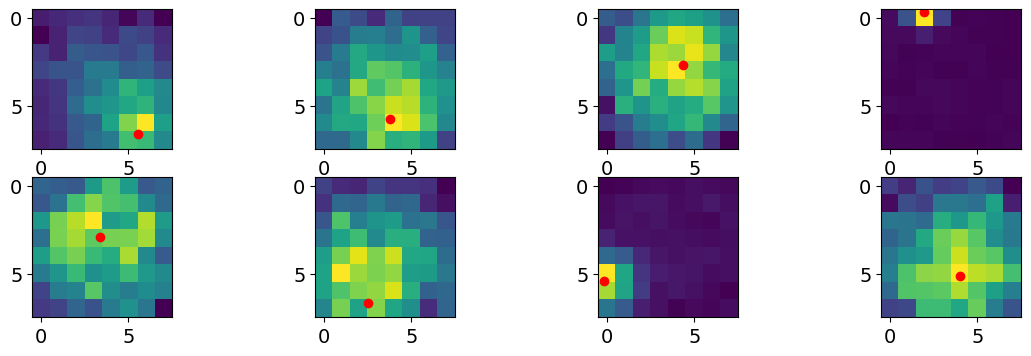

In [21]:
plot_images2(imgs, df1cs, (0,8), pixel_size = 6, grid_size=8)

In [22]:
energy = get_energy2(imgs)

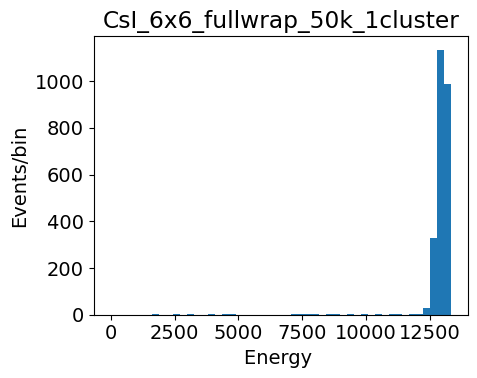

In [23]:
plot_energies2({"CsI_6x6_fullwrap_50k_1cluster":energy}, xmin=0, xmax=max(energy),num_bins = 50)

## Classification

In [24]:
first_file = 0  # initial file indx
last_file  = 100  # lasta file indx
batch_size = 200  # Batch size
train_fraction=0.7 
val_fraction=0.2

In [27]:
dataset = XDataset(dir_root, first_file, last_file,nc = False, norm=False)  

Running XDataset with norm = False
directory for 1c = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_vox_xy_6_z_12/df1c, 2c = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_vox_xy_6_z_12/df2c
 Image type = 0
 Image type = 1
Before shufle: length si: 512770, si->[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
After shufle: length si: 512770, si->[115481, 208736, 461043, 162373, 418200, 479114, 338695, 506523, 461126, 152977]


In [28]:
dataset[3]

(tensor([[[298., 313., 318., 259., 192., 187., 153., 131.],
          [310., 342., 349., 286., 239., 176., 156., 141.],
          [235., 316., 358., 288., 229., 219., 173., 149.],
          [221., 285., 276., 267., 205., 204., 152., 150.],
          [196., 228., 215., 219., 209., 198., 148., 155.],
          [178., 178., 202., 191., 193., 151., 142., 144.],
          [135., 175., 169., 173., 157., 155., 156., 127.],
          [129., 152., 154., 158., 165., 159., 141., 123.]]]),
 tensor(0))

In [29]:
data_loader, train_loader, val_loader, test_loader = mono_data_loader(dataset, 
                                                                      batch_size=batch_size, 
                                                                      train_fraction=train_fraction, 
                                                                      val_fraction=val_fraction)

Loaded 512770 events
 train size = 358939
 val size = 102554
 test size = 51277
 train indices = range(0, 358939)
 val indices = range(358939, 461493)
 test indices = range(461493, 512770)
358939 training events (70.0%)
102554 validation events (20.0%)
51277 test events (10.0%)


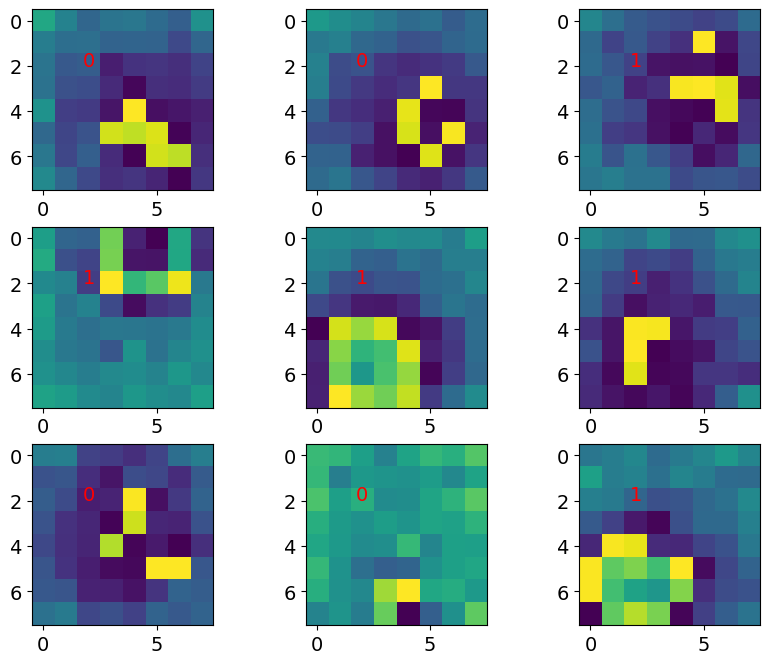

In [30]:
plot_images_and_labels(train_loader, start=100, figsize=(10, 8))

In [35]:
modelx = xResNet8(ResBlock, in_channels=1, out_channels=64, num_classes = 2, 
                 dropout_fraction=0.25, debug=True, dropout=True).to(device)

 ## make_layer 1: planes = 64,  blocks = 1, stride = 1
 ## make_layer: in_planes=64
 ## make_layer: downsample = None
 ## make_layer 2: planes = 128,  blocks = 1, stride = 2
 ## make_layer: in_planes=64
 ## make_layer: downsample = Sequential(
  (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
 ## make_layer 3: planes = 256,  blocks = 1, stride = 2
 ## make_layer: in_planes=128
 ## make_layer: downsample = Sequential(
  (0): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2))
  (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
 ## make_layer 4: planes = 512,  blocks = 1, stride = 2
 ## make_layer: in_planes=256
 ## make_layer: downsample = Sequential(
  (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2))
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [36]:
optimizer= optim.Adam(modelx.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [37]:
train_losses, val_losses, acc = x_train_cnn(train_loader, val_loader, modelx, optimizer, device, criterion, 
                                            batch_size=200, xc=True,
                                            iprnt=100, epochs=10)

Training with  ->359000 images
size of train loader  ->1795 images
Evaluating with  ->102600 images
size of eval loader  ->513 images
Classification  ->True
Running for epochs ->10

EPOCH 0
training step: size of sample 1795
  ResNet8: input data shape =>torch.Size([200, 1, 8, 8])
  ResNet8: after conv1 =>torch.Size([200, 64, 8, 8])
  ResNet8: after layer0 =>torch.Size([200, 64, 8, 8])
  ResNet8: after layer1 =>torch.Size([200, 128, 4, 4])
  ResNet8: after layer2 =>torch.Size([200, 256, 2, 2])
  ResNet8: after layer3 =>torch.Size([200, 512, 1, 1])
  ResNet8: after avgpool =>torch.Size([200, 512, 1, 1])
  ResNet8: after flatten =>torch.Size([200, 512])
  ResNet8: after fc =>torch.Size([200, 2])
Validation step: size of sample 513
--- EPOCH 0 AVG TRAIN LOSS: 0.6629896712834457
--- EPOCH 0 AVG VAL LOSS: 0.6687231670346176
Accuracy on the 513 validation images: 58.59937203814576 %

EPOCH 1
training step: size of sample 1795
Validation step: size of sample 513
--- EPOCH 1 AVG TRAIN LOSS: 0.

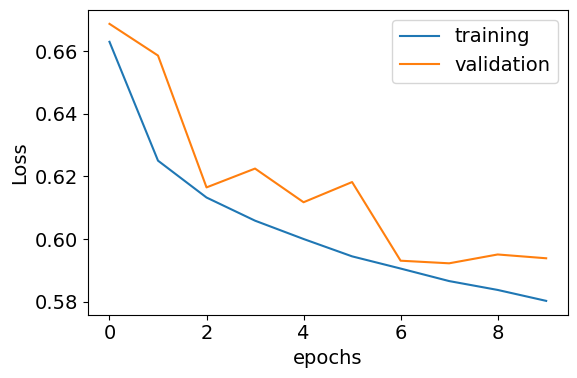

In [38]:
plot_loss(10, train_losses, val_losses,figsize=(6, 4))

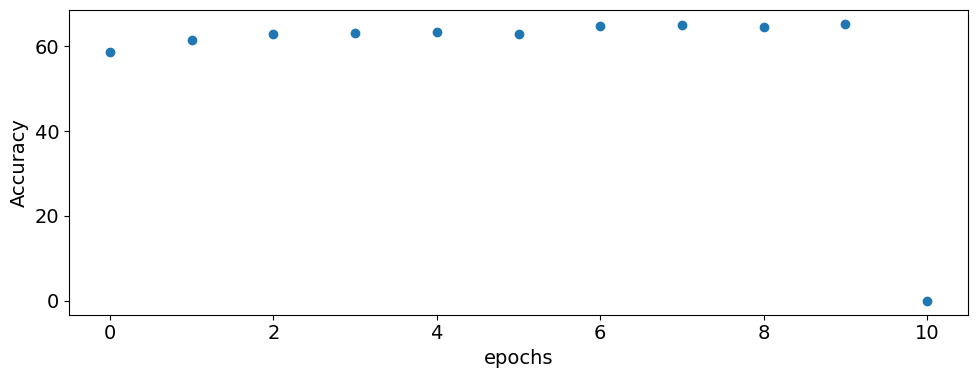

In [39]:
plot_accuracy(acc,figsize=(10, 4))

## Study accuracy

In [40]:
dataset1c = XDataset(dir_root, first_file, last_file, type="1c", nc = False, norm=False)  

Running XDataset with norm = False
directory for 1c = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_vox_xy_6_z_12/df1c, 2c = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_vox_xy_6_z_12/df2c
 Image type = 0
Before shufle: length si: 259889, si->[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
After shufle: length si: 259889, si->[158706, 130844, 49102, 234913, 104740, 22566, 185960, 52696, 23287, 54606]


In [41]:
data_loader = DataLoader(dataset1c, batch_size=10, shuffle=False) # data already shuffled

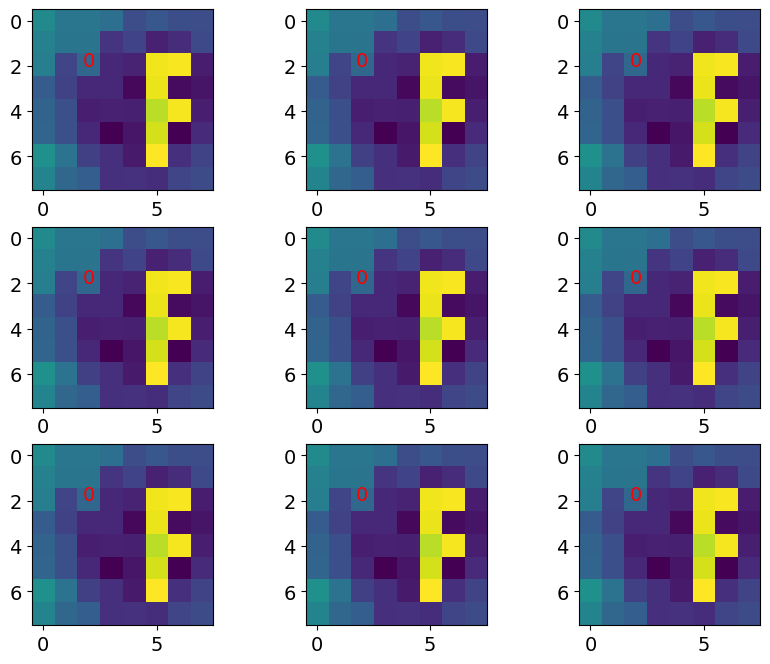

In [42]:
plot_images_and_labels(data_loader, start=0, figsize=(10, 8))

In [43]:
total, t1c, t2c, acc, c1c, c2c = cnn_xeval(test_loader, modelx, device, prnt=1000) 
print(f"Events analyzed = {total}: 1c = {t1c}, 2c = {t2c}")
print(f"Events correctly identified = {acc}")
print(f"1c correctly identified as 1c = {c1c}")
print(f"2c correctly identified as 2c = {c2c}")

Validation step: size of sample 257
i = 0
labels = tensor([0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0,
        0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1,
        1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
        1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1,
        0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1,
        0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0,
        1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0,
        0, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
predicted = tensor([0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1,
        0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
        1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       

### In conclusion, with binning of 3 mm, accuracy is poor for 1c

## 9 mm

In [50]:
data_dir = Path(os.environ['MONOLITH_DATA'])
dir_root = os.path.join(data_dir,"CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_2_vox_9mm")
d1c = os.path.join(dir_root,"df1c")
d2c = os.path.join(dir_root,"df2c")
dnc = os.path.join(dir_root,"dfnc")


In [51]:
dataset = XDataset(dir_root, first_file, last_file,numcls=2, norm=False)  

Running XDataset with norm = False
directory for 1c = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_2_vox_9mm/df1c, 2c = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_2_vox_9mm/df2c, >2c = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_2_vox_9mm/dfnc
 Image type = 0
 Image type = 1
 Image type = 1
Before shufle: length si: 1026373, si->[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
After shufle: length si: 1026373, si->[683351, 990430, 60366, 144967, 580279, 564105, 326124, 316465, 671872, 789973]


In [52]:
data_loader, train_loader, val_loader, test_loader = mono_data_loader(dataset, 
                                                                      batch_size=batch_size, 
                                                                      train_fraction=train_fraction, 
                                                                      val_fraction=val_fraction)

Loaded 1026373 events
 train size = 718461
 val size = 205274
 test size = 102638
 train indices = range(0, 718461)
 val indices = range(718461, 923735)
 test indices = range(923735, 1026373)
718461 training events (69.99999025695337%)
205274 validation events (19.99994154172021%)
102638 test events (10.000068201326417%)


In [53]:
modelx = xResNet8(ResBlock, in_channels=1, out_channels=64, num_classes = 2, 
                 dropout_fraction=0.25, debug=True, dropout=True).to(device)
optimizer= optim.Adam(modelx.parameters(), lr=0.001)

 ## make_layer 1: planes = 64,  blocks = 1, stride = 1
 ## make_layer: in_planes=64
 ## make_layer: downsample = None
 ## make_layer 2: planes = 128,  blocks = 1, stride = 2
 ## make_layer: in_planes=64
 ## make_layer: downsample = Sequential(
  (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
 ## make_layer 3: planes = 256,  blocks = 1, stride = 2
 ## make_layer: in_planes=128
 ## make_layer: downsample = Sequential(
  (0): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2))
  (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
 ## make_layer 4: planes = 512,  blocks = 1, stride = 2
 ## make_layer: in_planes=256
 ## make_layer: downsample = Sequential(
  (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2))
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [54]:
train_losses, val_losses, acc = x_train_cnn(train_loader, val_loader, modelx, optimizer, device, criterion, 
                                            batch_size=200, xc=True,
                                            iprnt=100, epochs=10)

Training with  ->718600 images
size of train loader  ->3593 images
Evaluating with  ->205400 images
size of eval loader  ->1027 images
Classification  ->True
Running for epochs ->10

EPOCH 0
training step: size of sample 3593
  ResNet8: input data shape =>torch.Size([200, 1, 8, 8])
  ResNet8: after conv1 =>torch.Size([200, 64, 8, 8])
  ResNet8: after layer0 =>torch.Size([200, 64, 8, 8])
  ResNet8: after layer1 =>torch.Size([200, 128, 4, 4])
  ResNet8: after layer2 =>torch.Size([200, 256, 2, 2])
  ResNet8: after layer3 =>torch.Size([200, 512, 1, 1])
  ResNet8: after avgpool =>torch.Size([200, 512, 1, 1])
  ResNet8: after flatten =>torch.Size([200, 512])
  ResNet8: after fc =>torch.Size([200, 2])
Validation step: size of sample 1027
--- EPOCH 0 AVG TRAIN LOSS: 0.63231298613608
--- EPOCH 0 AVG VAL LOSS: 0.6143675156031982
Accuracy on the 1027 validation images: 64.0017732396699 %

EPOCH 1
training step: size of sample 3593
Validation step: size of sample 1027
--- EPOCH 1 AVG TRAIN LOSS: 0

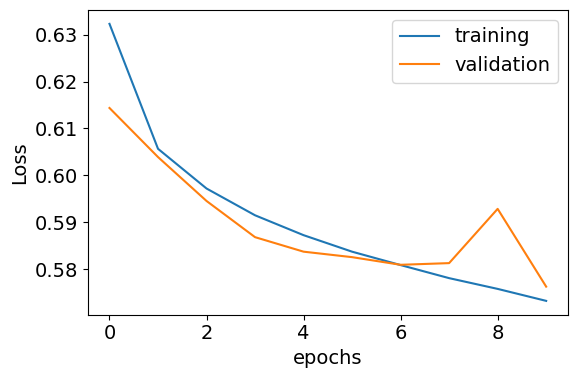

In [55]:
plot_loss(10, train_losses, val_losses,figsize=(6, 4))

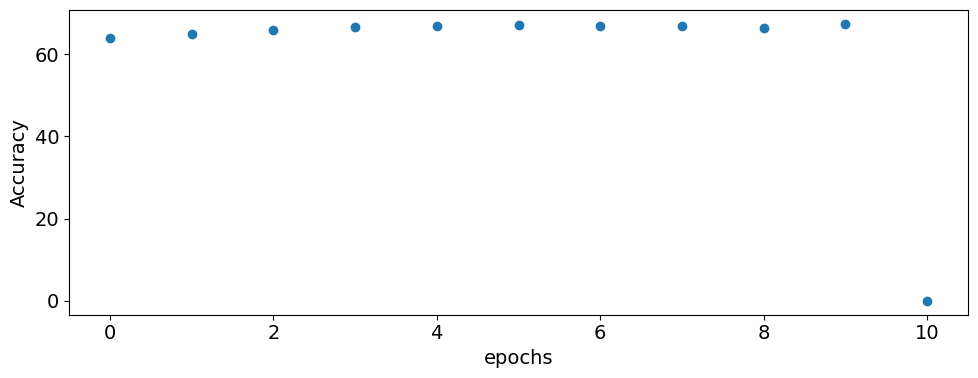

In [56]:
plot_accuracy(acc,figsize=(10, 4))

In [59]:
total, t1c, t2c, acc, c1c, c2c = cnn_xeval(test_loader, modelx, device, prnt=1000) 
print(f"Events analyzed = {total}: 1c = {t1c}, 2c = {t2c}")
print(f"Events correctly identified = {acc}")
print(f"1c correctly identified as 1c = {c1c}")
print(f"2c correctly identified as 2c = {c2c}")

Validation step: size of sample 514
i = 0
labels = tensor([0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0,
        1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1,
        1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
        1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0,
        1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
        0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 0, 1, 1], device='cuda:0')
predicted = tensor([0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       

## 14 mm

In [60]:
data_dir = Path(os.environ['MONOLITH_DATA'])
dir_root = os.path.join(data_dir,"CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_2_vox_14mm")
d1c = os.path.join(dir_root,"df1c")
d2c = os.path.join(dir_root,"df2c")
dnc = os.path.join(dir_root,"dfnc")
dataset = XDataset(dir_root, first_file, last_file,numcls=2, norm=False)  
data_loader, train_loader, val_loader, test_loader = mono_data_loader(dataset, 
                                                                      batch_size=batch_size, 
                                                                      train_fraction=train_fraction, 
                                                                      val_fraction=val_fraction)
modelx = xResNet8(ResBlock, in_channels=1, out_channels=64, num_classes = 2, 
                 dropout_fraction=0.25, debug=True, dropout=True).to(device)
optimizer= optim.Adam(modelx.parameters(), lr=0.001)

Running XDataset with norm = False
directory for 1c = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_2_vox_14mm/df1c, 2c = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_2_vox_14mm/df2c, >2c = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_2_vox_14mm/dfnc
 Image type = 0
 Image type = 1
 Image type = 1
Before shufle: length si: 1026373, si->[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
After shufle: length si: 1026373, si->[683351, 990430, 60366, 144967, 580279, 564105, 326124, 316465, 671872, 789973]
Loaded 1026373 events
 train size = 718461
 val size = 205274
 test size = 102638
 train indices = range(0, 718461)
 val indices = range(718461, 923735)
 test indices = range(923735, 1026373)
718461 training events (69.99999025695337%)
205274 validation events (19.99994154172021%)
102638 test events (10.000068201326417%)
 ## make_layer 1: planes = 64,  blocks = 1, stride = 1
 ## make_layer: in_planes

In [61]:
train_losses, val_losses, acc = x_train_cnn(train_loader, val_loader, modelx, optimizer, device, criterion, 
                                            batch_size=200, xc=True,
                                            iprnt=100, epochs=10)

Training with  ->718600 images
size of train loader  ->3593 images
Evaluating with  ->205400 images
size of eval loader  ->1027 images
Classification  ->True
Running for epochs ->10

EPOCH 0
training step: size of sample 3593
  ResNet8: input data shape =>torch.Size([200, 1, 8, 8])
  ResNet8: after conv1 =>torch.Size([200, 64, 8, 8])
  ResNet8: after layer0 =>torch.Size([200, 64, 8, 8])
  ResNet8: after layer1 =>torch.Size([200, 128, 4, 4])
  ResNet8: after layer2 =>torch.Size([200, 256, 2, 2])
  ResNet8: after layer3 =>torch.Size([200, 512, 1, 1])
  ResNet8: after avgpool =>torch.Size([200, 512, 1, 1])
  ResNet8: after flatten =>torch.Size([200, 512])
  ResNet8: after fc =>torch.Size([200, 2])
Validation step: size of sample 1027
--- EPOCH 0 AVG TRAIN LOSS: 0.5934285998526901
--- EPOCH 0 AVG VAL LOSS: 0.6069861579080635
Accuracy on the 1027 validation images: 68.35546635229011 %

EPOCH 1
training step: size of sample 3593
Validation step: size of sample 1027
--- EPOCH 1 AVG TRAIN LOSS

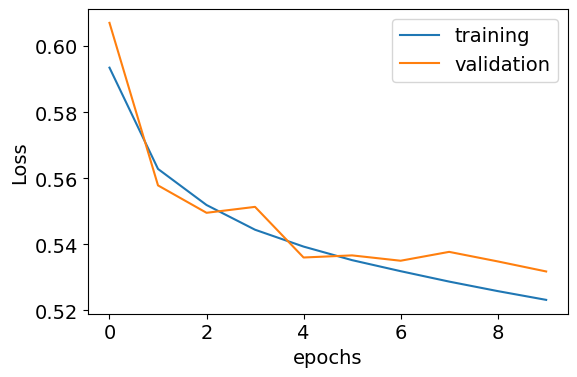

In [62]:
plot_loss(10, train_losses, val_losses,figsize=(6, 4))

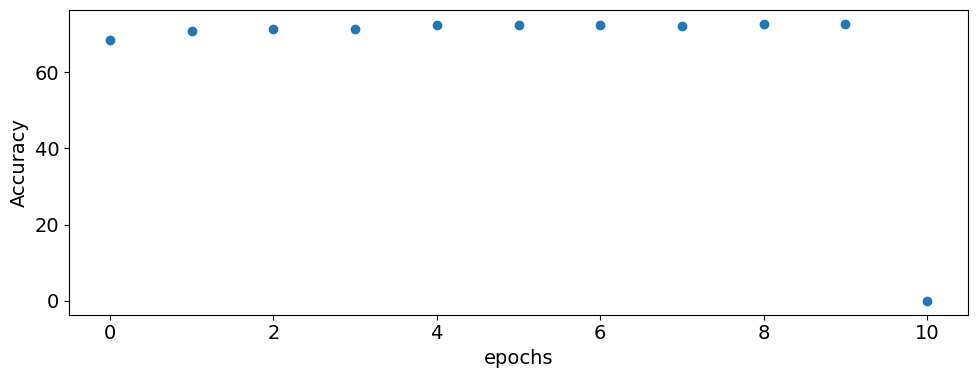

In [63]:
plot_accuracy(acc,figsize=(10, 4))

In [64]:
total, t1c, t2c, acc, c1c, c2c = cnn_xeval(test_loader, modelx, device, prnt=1000) 
print(f"Events analyzed = {total}: 1c = {t1c}, 2c = {t2c}")
print(f"Events correctly identified = {acc}")
print(f"1c correctly identified as 1c = {c1c}")
print(f"2c correctly identified as 2c = {c2c}")

Validation step: size of sample 514
i = 0
labels = tensor([0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
        1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
        1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1,
        0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
        1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0,
        1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 0, 1, 1], device='cuda:0')
predicted = tensor([0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,
        0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       